![alt text](https://i.imgur.com/1WaY7aA.png)

---



---



# Data Science and AI
## Demo 9.6: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

In [7]:
# source is separated by <tab>s and has no headers
df_yelp = pd.read_csv('../../DATA/yelp_labelled.txt', header = None, sep = '\t')
df_imdb = pd.read_csv('../../DATA/imdb_labelled_fixed.txt', header = None, sep = '\t') # New file without double quotes
df_amazon = pd.read_csv('../../DATA/amazon_cells_labelled.txt', header = None, sep = '\t')
dfs = {'yelp': df_yelp, 'imdb': df_imdb, 'amazon': df_amazon}

## Inspect the data

In [8]:
# - assign column names
# - add the data source
# - check the data
for ds in dfs.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs[ds].shape[0], dfs[ds].shape[1]))
    dfs[ds].columns = ['text', 'sentiment']
    dfs[ds]['source'] = ds
    print(dfs[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1  

## Note:
All the datasets should have _1000_ records each. The **imbd** dataset only shows _748_ records!!

**Why**?

In [9]:
# pd.Series(df_imdb[10:30]['text'].apply(len))
# check the distribution of lenght of texts
pd.Series(df_imdb['text'].apply(len)).describe()

count    1000.000000
mean       82.188000
std        56.244966
min         7.000000
25%        41.000000
50%        68.000000
75%       108.250000
max       479.000000
Name: text, dtype: float64

The mean of text's len is _110_ while the largest is _7944_ characters long!

In [10]:
l = df_imdb['text'].map(len)
for i, s in zip(l.index, l):
    if s > 1000:
        print('index: %3d, size: %4d\ntext |%s|\n' % (i, s, df_imdb.iloc[i]['text']))
        print('-' * 80)

The source data from imdb har umbalanced double quotes (").

As the file is small, it can be edited manually.

In a Unix/Unix like system, it can be fixed with the command:

    cat imdb_labelled.txt | tr -d '"' > imdb_labelled_fixed.txt

## Merge the data

In [11]:
df = pd.concat(dfs.values(), ignore_index = True)

In [12]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))
print('-' * 75)

Dataset: All [3000 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
text         3000 non-null object
sentiment    3000 non-null int64
source       3000 non-null object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None
                                                   text  sentiment  source
1345                          Babie Bop is very cute.            1    imdb
189   Also were served hot bread and butter, and hom...          1    yelp
2259             Great for using with your home stereo.          1  amazon
2854                            Comfortable in my hand.          1  amazon
2850                                It looks very nice.          1  amazon
1704                 DELETE this film from your mind!            0    imdb
1574  Aside from it's terrible lead, this film has l...          0    imdb
620     I had the chicken Pho and it tasted very bland.          0    yelp
1392  I think it was Ro

## Export the data

In [14]:
df.to_csv('../../DATA/sentiments.csv', index = None)

## Prepare the stage
- Load spaCy

In [15]:
nlp = spacy.load('en')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle simbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

In [16]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [17]:
df['text'] = df['text'].apply(clean_text)

## Work the text
Concern with the meaning and the substance of the content to extract actual information.

In [18]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [19]:
%%time
df['short'] = df['text'].apply(convert_text)

Wall time: 42.4 s


In [20]:
df.sample(10)

,text,sentiment,source,short
422,"Furthermore, you can't even find hours of oper...",0,yelp,furthermore not find hours operation website
1087,The Wind and the Lion is well written and supe...,1,imdb,the wind Lion write superbly act
300,Good beer & drink selection and good food sele...,1,yelp,good beer drink selection good food selection
261,"I have been in more than a few bars in Vegas, ...",0,yelp,-pron- bar Vegas recall charge tap water
2436,I wish I could return the unit and get back my...,0,amazon,-pron- wish -pron- return unit money
506,Overall I wasn't very impressed with Noca.,0,yelp,overall -pron- not impressed Noca
1659,"If you love death and decay, and Shakespears l...",1,imdb,if love death decay Shakespears lyric
2702,* Comes with a strong light that you can use t...,1,amazon,come strong light use light camera shot flash ...
905,"Also, I feel like the chips are bought, not ma...",0,yelp,also -pron- feel like chip buy house
1539,i wouldnt see this movie again for free.,0,imdb,not movie free


## Modelling

In [21]:
# helper function to show results and charts
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [22]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [23]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [24]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [25]:
# create a classifier using SVC
classifier = LinearSVC()

In [26]:
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [27]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [28]:
# make predictions based on the test data
predictions = classifier.predict(B)

In [29]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [30]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B)

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7983


## Repeating it all for comparision
Repeating the whole lot in one big block

*********
* Count *
*********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7806 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7961 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7832                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


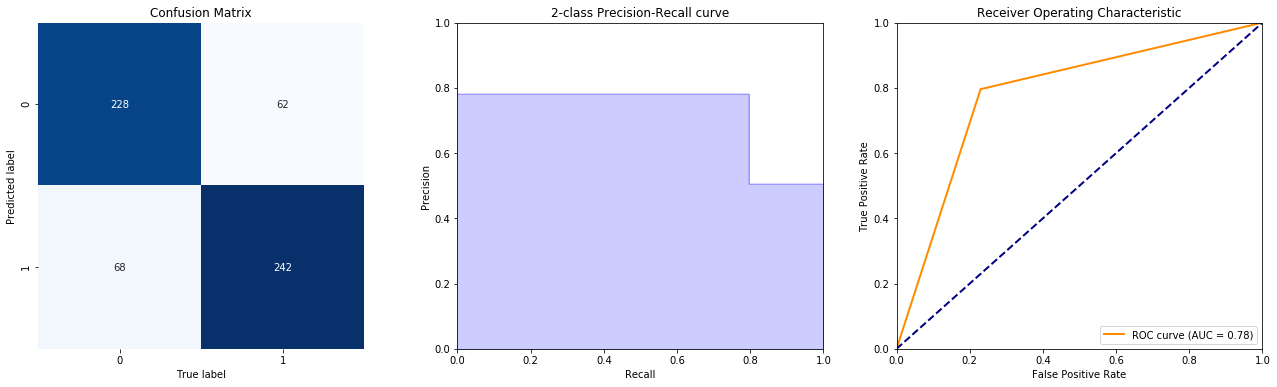


**********
* TF-IDX *
**********
Accuracy : 0.7983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8026 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


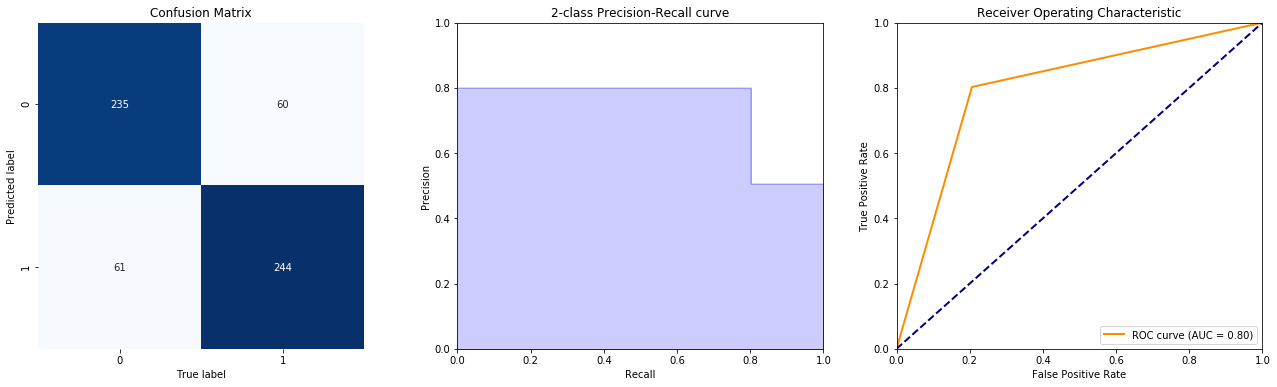

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.783333,0.780645,0.796053,0.783161
1,TF-IDX,0.798333,0.800000,0.802632,0.798275


In [31]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = LinearSVC()

    # train the classifier with the training data
    classifier.fit(A.toarray(), y_train)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B)

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

>

>

>



---



---



> > > > > > > > > © 2019 Data Science Institute of Australia


---



---



